In [9]:
# Imports
import scipy
from scipy.signal import windows
from scipy.fft import fft
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm

In [10]:
window_size_options = [0.1, 0.2, 0.5, 1, 20] # seconds
generated_data = []

In [11]:

# Generating data, which is a list of spectrums for each window size.

sampling_rate = 1000  # Hz
aperiodic_exponent = 2.0
aperiodic_offset = 2.0
knee = 200
peaks = [{'freq': 12, 'amplitude': 1, 'sigma': 2}]

for i, window in enumerate(window_size_options):
    generated_data.append(spectrum(
        sampling_rate=sampling_rate,
        duration=window,
        aperiodic_exponent=aperiodic_exponent,
        aperiodic_offset=aperiodic_offset,
        knee=knee,
        peaks=peaks,
        average_firing_rate=0,
        random_state=42,
        direct_estimate=True,  # skip empirical PSD
        plot=False
    ))

In [12]:
"""
This function plots and returns the single taper spectral estimates for the given spectrum, assuming no Welch's method.
Args:
    spectrum (spectrum): The spectrum object containing time domain (combined broadband and rhythmic) data.
    taper_options (list): List of taper options to apply (strings).
    sampling_rate (float): The sampling rate of the signal.
Returns: 
    tuple: List of positive frequencies and the corresponding FFT results. Number of elements in the list is equal to the number of taper options.
"""
def plot_single_taper(spectrum, taper_options, sampling_rate): 
    N = len(spectrum.time_domain.combined_signal)
    fft_result = [0 for i in range(len(taper_options))] 
    for i, taper in enumerate(taper_options):
        tapered_signal = spectrum.time_domain.combined_signal * windows.get_window(taper, N)
        freqs = np.fft.fftfreq(N, d=1/sampling_rate)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
        fft_result[i] = ((np.abs(fft(tapered_signal)[1:N//2]))**2) / (sampling_rate*N)
        plt.loglog(freqs, np.abs(fft_result[i]), label=taper, linewidth=1, alpha=0.5)
    return (freqs, fft_result)

"""
This function plots and returns the multitaper spectral estimates for the given spectrum, averaging the results across multiple DPSS tapers
and also providing the option for using just one DPSS taper. The latter may be useful for comparing directly with the single taper method.

Args:
    spectrum (spectrum): The spectrum object containing time domain (combined broadband and rhythmic) data.
    duration (float): The duration of the signal in seconds. We assume this is the window of the taper.
    sampling_rate (float): The sampling rate of the signal.
    isOneTaper (bool): If True, only one DPSS taper is used. If False, multiple DPSS tapers are used.
Returns: 
    tuple: Positive frequencies and the corresponding FFT results.
"""
def plot_multi_taper(spectrum, duration, sampling_rate, isOneTaper=False):
    N = len(spectrum.time_domain.time)
    t_w = 1 # N/2 - 1 if (duration*sampling_rate/2>=N/2) else duration*sampling_rate/2
    if isOneTaper:
        L = 1
    else:
        L = math.floor(t_w)-1
        print(L)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
    tapered_signals = np.array([np.abs(fft(spectrum.time_domain.combined_signal * taper)) ** 2 / (sampling_rate * N * (1/N * np.sum(windows.dpss(N, t_w, L) ** 2))) for taper in windows.dpss(N, t_w, L)])  # divide by Welch normalization factor U = 1/L * Σ w(n)^2
    fft_result = (np.sum(tapered_signals, axis=0) / len(tapered_signals))[1:N//2]
    plt.loglog(freqs, np.abs(fft_result), label='DPSS', linewidth=1, alpha=0.5)
    return (freqs, fft_result)


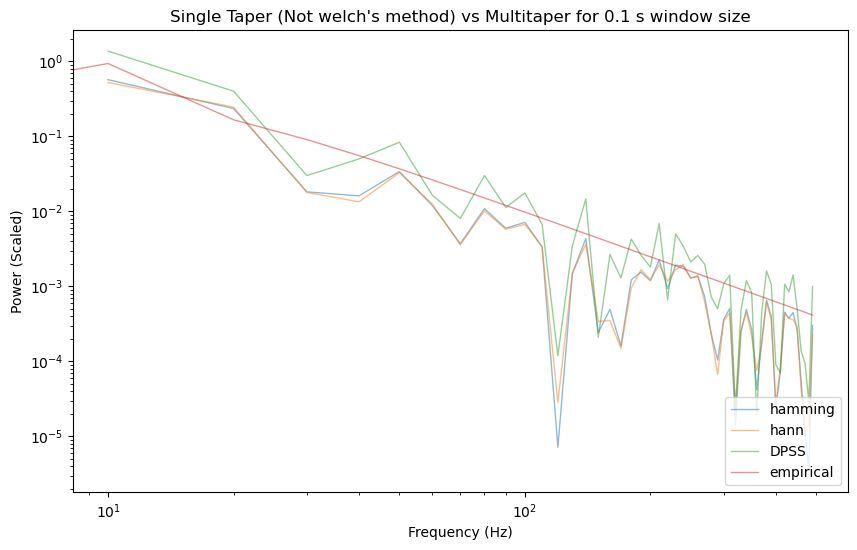

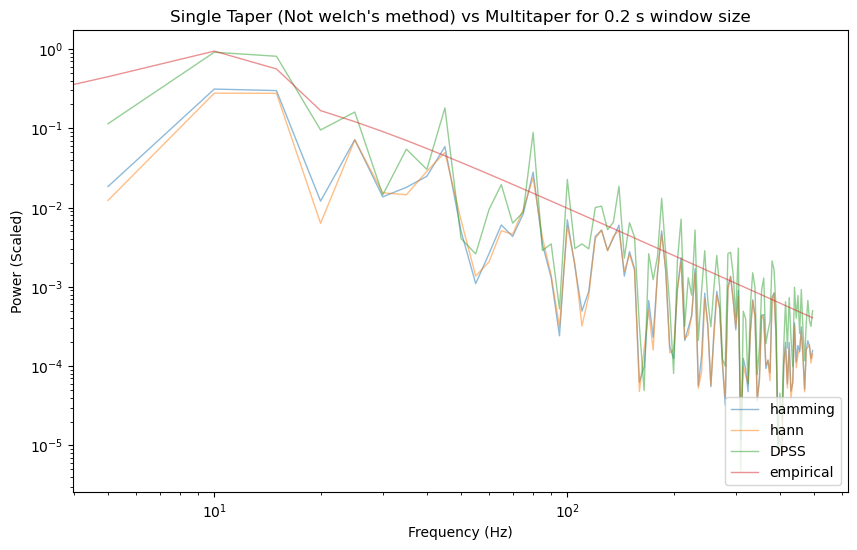

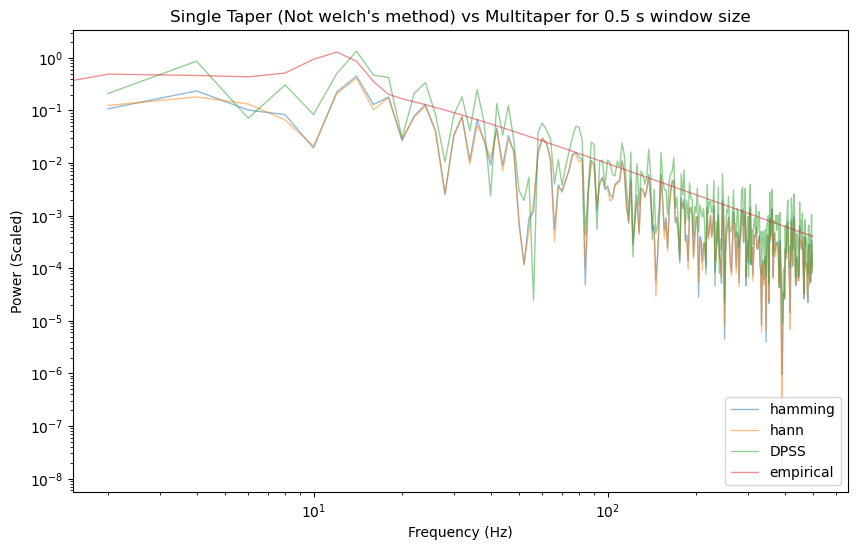

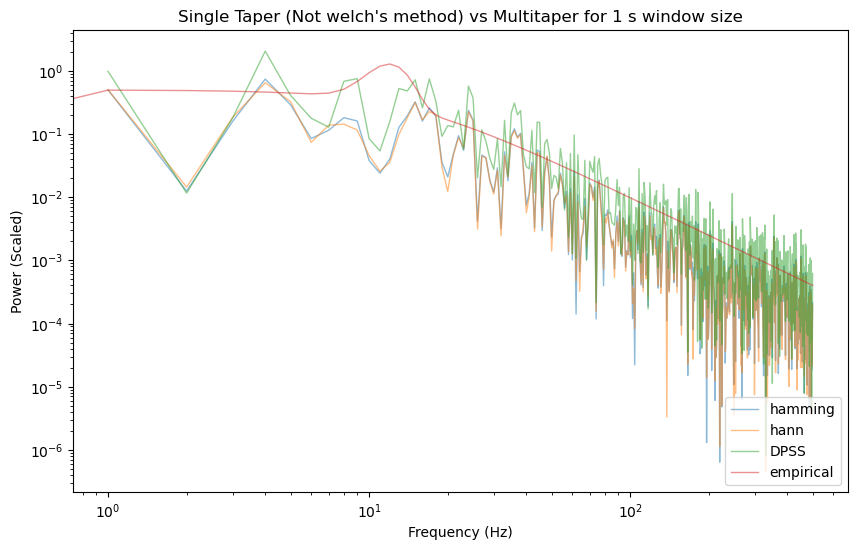

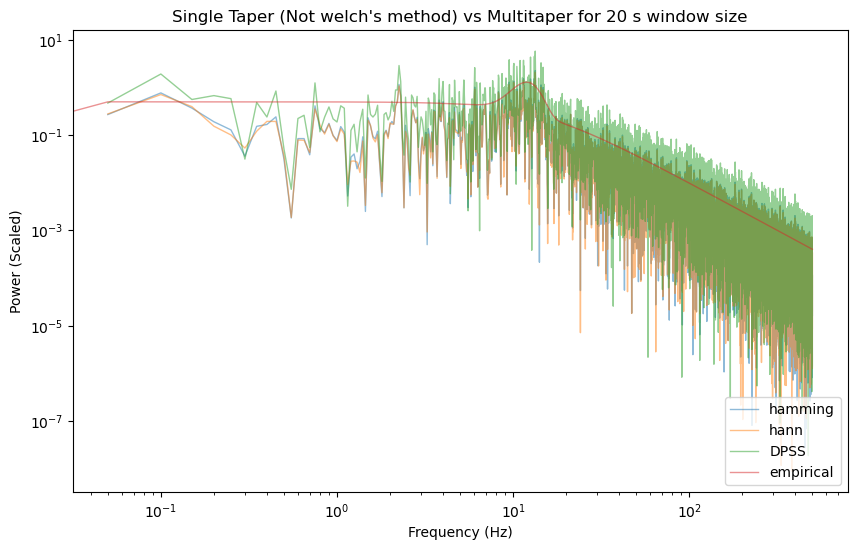

In [13]:
# Call the defined functions over all the generated data.

# Storing the FFT results for single taper and multitaper methods for each window size.

frqs_single, fft_result_single = [[] for i in range(len(window_size_options))], [[] for i in range(len(window_size_options))] 
# The single taper may have multiple tapers for each window size (based on what tapers the user chooses).
# For example, if the user chooses 'hamming' and 'hann', then the single taper will have two results for each window size.

frqs_multi, fft_result_multi = [0 for i in range(len(window_size_options))], [0 for i in range(len(window_size_options))]

taper_options = ['hamming', 'hann']  # Taper options for single taper method

for i, window in enumerate(window_size_options):
    # Plot setup
    plt.figure(figsize=(10, 6))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (Scaled)")
    plt.title(f"Single Taper (Not welch's method) vs Multitaper for {window} s window size")

    # Store FFT results
    frqs_single[i], fft_result_single[i] = plot_single_taper(generated_data[i], taper_options=taper_options, sampling_rate=sampling_rate)
    frqs_multi[i], fft_result_multi[i] = plot_multi_taper(generated_data[i], duration=window_size_options[i], sampling_rate=sampling_rate, isOneTaper=True)

    # Plot empirical PSD
    N = len(generated_data[i].time_domain.combined_signal)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)[0:N//2] # starting from 1 to avoid a divide by 0 error later.
    plt.loglog(freqs, generated_data[i].frequency_domain.combined_spectrum, linewidth=1, alpha=0.5, label='empirical')

    plt.legend(loc="lower right")

    

In [14]:
# multi was already scaled during original taper computation
def u_scaling(fft_result_single, N): # https://www.mathworks.com/help/signal/ug/nonparametric-methods.html#f12-16152 
    scaled_fft_single = [[0 for i in range(len(taper_options))] for i in range(len(window_size_options))] # first index: window size, second index: taper
    # Scale the FFT results for single taper
    for window_index, single in enumerate(fft_result_single):
        for taper_index in range(len(single)):
            window = windows.get_window(taper_options[taper_index], N)
            U = 1/N * sum(i**2 for i in window)
            scaled_fft_single[window_index][taper_index] = [i/U for i in np.abs(single[taper_index])] #i*(2/sampling_rate)
    
    return scaled_fft_single

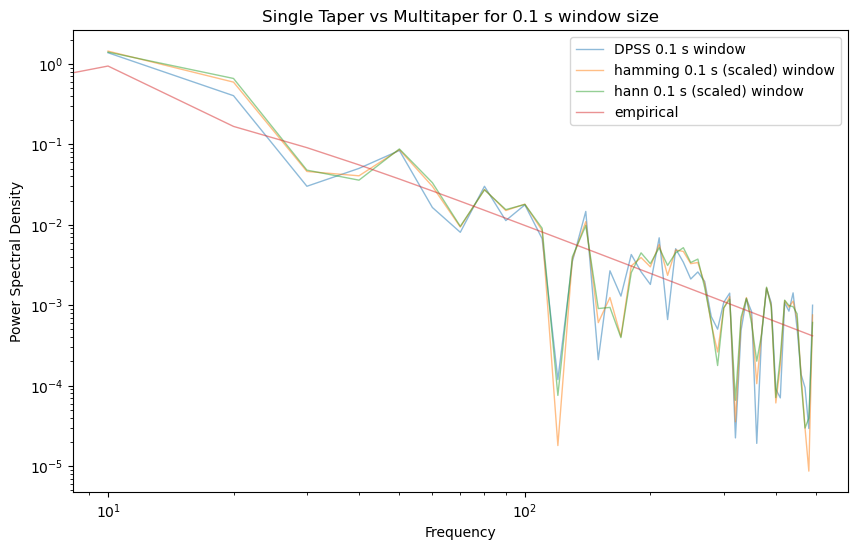

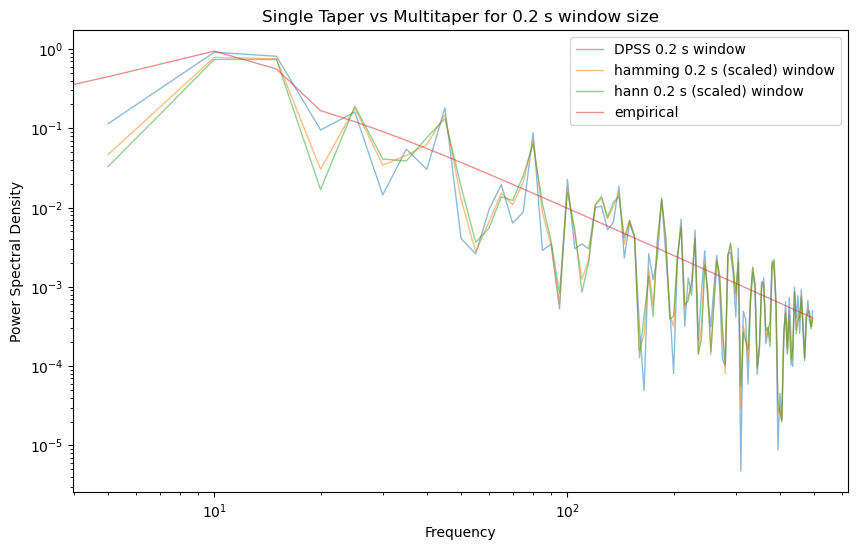

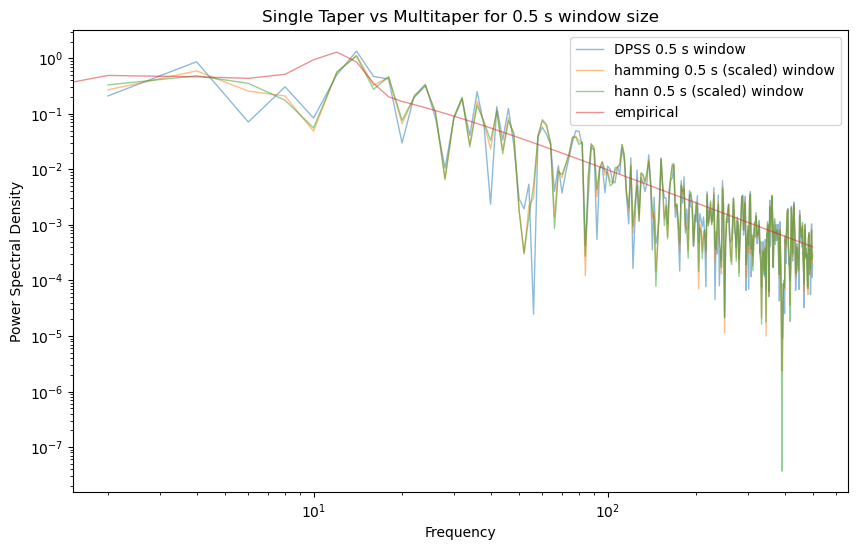

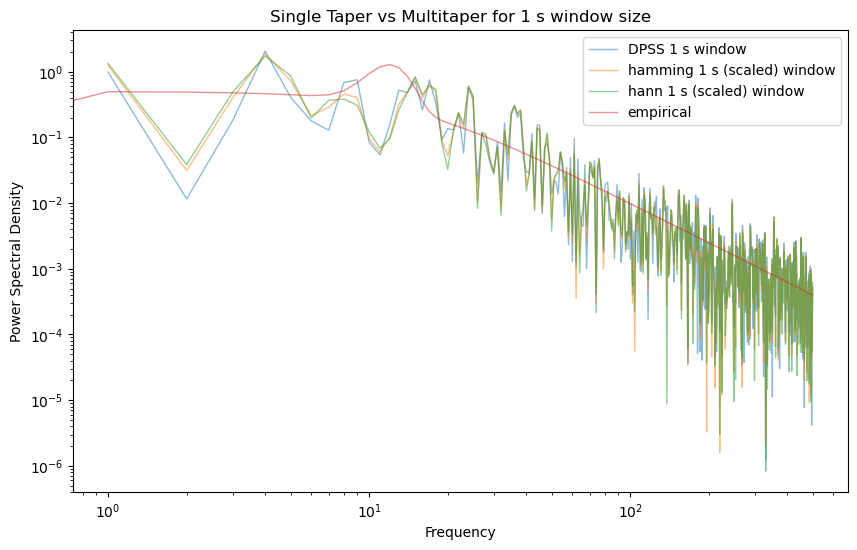

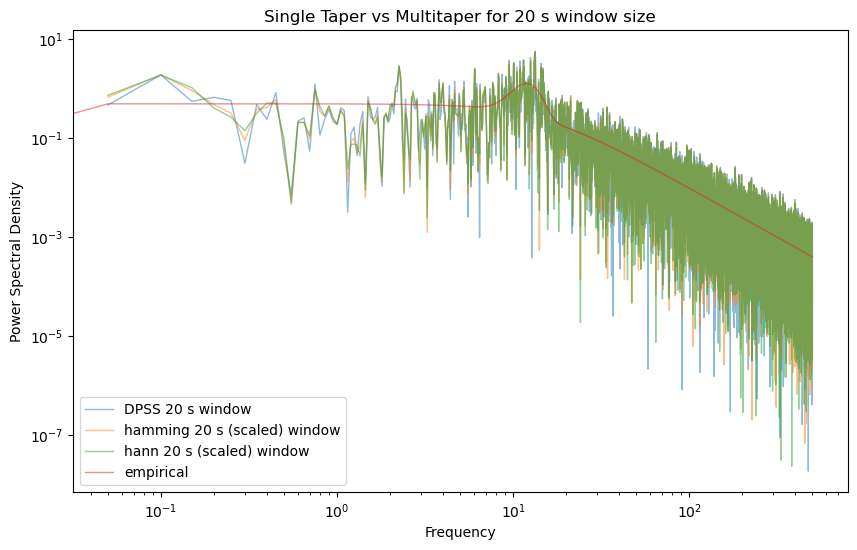

In [15]:
scaled_fft_single = u_scaling(fft_result_single, N=len(generated_data[0].time_domain.combined_signal))

# Plot scaled singletaper results
for plotting_window_index in range(len(window_size_options)):
    plt.figure(figsize=(10, 6))
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.title(f"Single Taper vs Multitaper for {window_size_options[plotting_window_index]} s window size")
    # Plot multi taper results
    plt.loglog(frqs_multi[plotting_window_index], np.abs(fft_result_multi[plotting_window_index]), label=f'DPSS {window_size_options[plotting_window_index]} s window', linewidth=1, alpha=0.5)
    for taper_index in range(len(taper_options)):
        # Plot single taper results
        plt.loglog(frqs_single[plotting_window_index], np.abs(scaled_fft_single[plotting_window_index][taper_index]), label=f'{taper_options[taper_index]} {window_size_options[plotting_window_index]} s (scaled) window', linewidth=1, alpha=0.5)
    # Plot empirical PSD
    N = len(generated_data[plotting_window_index].time_domain.combined_signal)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)[0:N//2] # starting from 1 to avoid a divide by 0 error later.
    plt.loglog(freqs, generated_data[plotting_window_index].frequency_domain.combined_spectrum, linewidth=1, alpha=0.5, label='empirical')
    plt.legend()

plt.legend()

# Currently Unused Code
- QQ Plot
    ```python
    # just trying something, may not be appropriate to do a QQ plot in this context but I think they did it in the paper?
    # not sure why it's so bad or if it's expected to be this bad.
    residuals = generated_data[2].frequency_domain.combined_spectrum - fft_result_multi[2]
    fig = sm.qqplot(residuals)
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), 'r--', lw=2)
    plt.show()
- Spectogram
    ```python
    import matplotlib as mat
    NFFT = len(generated_data[0].frequency_domain.combined_spectrum)
    plt.specgram(
        generated_data[3].frequency_domain.combined_spectrum,
        Fs=sampling_rate,
        window=mat.mlab.window_hanning(np.ones(NFFT)),
        NFFT=NFFT,
        sides='onesided',
        noverlap=NFFT // 2, # I don't know why we're doing this?
        cmap='viridis'
    )
- Welch
    ```python
    from scipy.signal import welch
    def welch_psd(signal, taper_options, fs=1000, duration=None, overlap=0):
        N = len(signal)
        nperseg = N if duration is None else int(duration * fs) # number of samples per segment
        noverlap = int(nperseg * overlap) # number of samples per overlap

        freqs, psd = welch(signal,
                        fs=fs,
                        window=taper_options,
                        nperseg=nperseg,
                        noverlap=noverlap,
                        scaling='density' # return psd
                        )

        return freqs, psd
- Scaling
    ```python
    from sklearn.preprocessing import MinMaxScaler
    """
    This function scales the FFT results using Min-Max normalization.
    Args:
        fft_result_multi (list): List of FFT results for multi-taper method.
        fft_result_single (list): List of FFT results for single-taper method.
    Returns:
        tuple: Scaled FFT results for multi-taper and single-taper methods.
    """
    def min_max_normalization(fft_result_multi, fft_result_single):
        scaled_fft_multi = [0 for i in range(len(window_size_options))] # index by window size
        scaled_fft_single = [[0 for i in range(len(taper_options))] for i in range(len(window_size_options))] # first index: window size, second index: taper

        # Scale the FFT results for multi taper
        for i, multi in enumerate(fft_result_multi):
            data_to_scale = np.abs(multi).reshape(-1, 1)
            scaled_fft_multi[i] = MinMaxScaler().fit(data_to_scale).transform(data_to_scale)

        # Scale the FFT results for single taper
        for window_index, single in enumerate(fft_result_single):
            for taper_index in range(len(single)):
                data_to_scale = np.abs(single)[taper_index].reshape(-1, 1)
                scaled_fft_single[window_index][taper_index] = MinMaxScaler().fit(data_to_scale).transform(data_to_scale)
        
        return scaled_fft_multi, scaled_fft_single

    """
    This function scales the FFT results using area normalization.
    Args:
        fft_result_multi (list): List of FFT results for multi-taper method.
        fft_result_single (list): List of FFT results for single-taper method.
    Returns:
        tuple: Scaled FFT results for multi-taper and single-taper methods.
    """
    def area_normalization(fft_result_multi, fft_result_single):
        scaled_fft_multi = [0 for i in range(len(window_size_options))] # index by window size
        scaled_fft_single = [[0 for i in range(len(taper_options))] for i in range(len(window_size_options))] # first index: window size, second index: taper

        # Scale the FFT results for multi taper
        for i, multi in enumerate(fft_result_multi):
            sum_multi = np.sum(np.abs(multi))
            scaled_fft_multi[i] = [i/sum_multi for i in np.abs(multi)]

        # Scale the FFT results for single taper
        for window_index, single in enumerate(fft_result_single):
            for taper_index in range(len(single)):
                sum_single = np.sum(np.abs(single[taper_index]))
                scaled_fft_single[i][taper_index] = [i/sum_multi for i in np.abs(single[taper_index])]
        
        return scaled_fft_multi, scaled_fft_single

